Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Predicting...
Bucket name is:


2022-11-23 18:49:44.577831: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-23 18:49:44.577879: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-189-149.ec2.internal): /proc/driver/nvidia/version does not exist
2022-11-23 18:49:44.578457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded model from MODEL_LOCATION
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


The class sagemaker.tensorflow.serving.Model has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py:514: _colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


2022-11-23 18:51:49.408073: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Done.


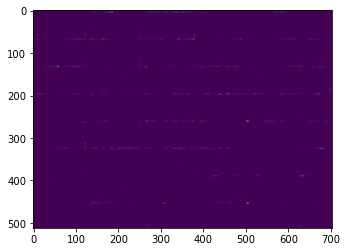

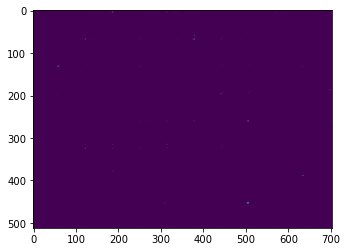

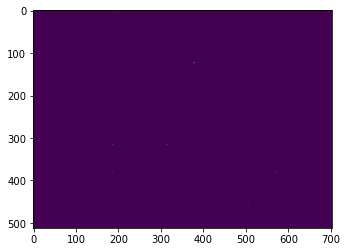

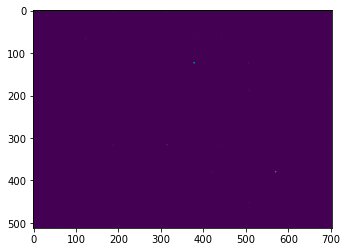

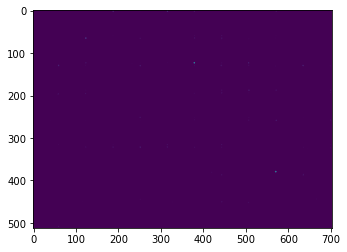

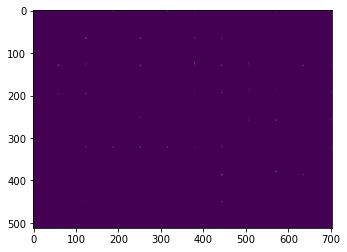

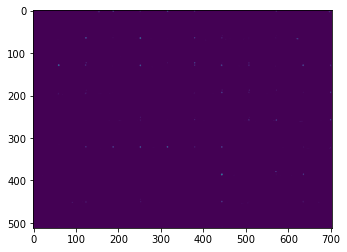

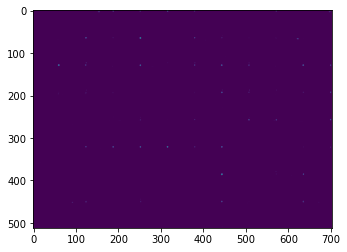

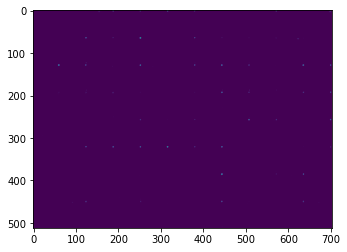

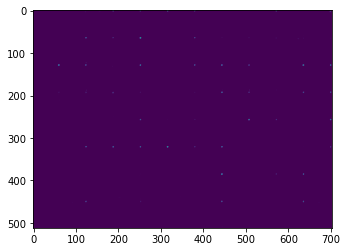

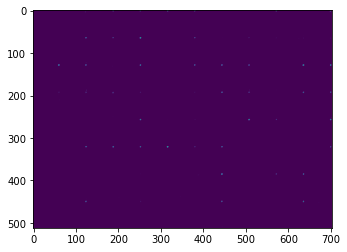

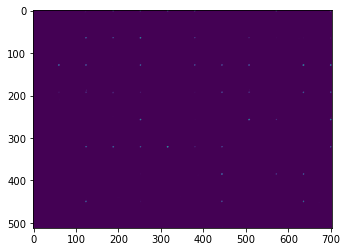

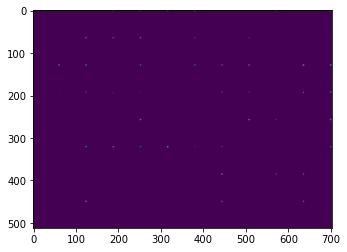

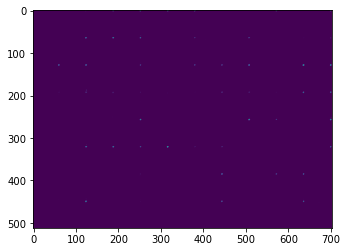

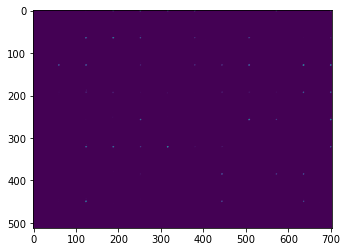

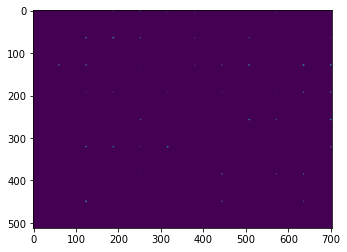

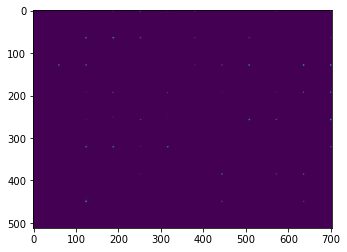

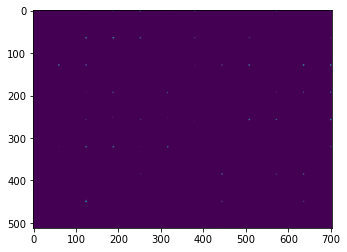

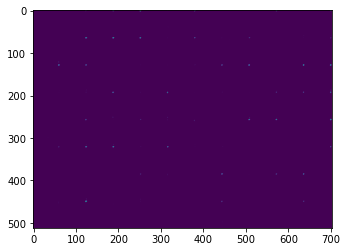

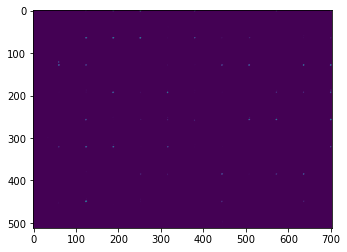

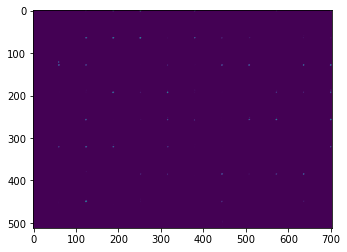

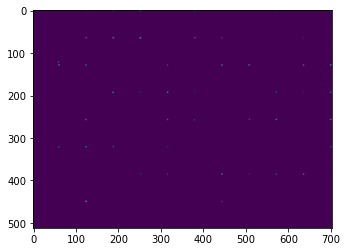

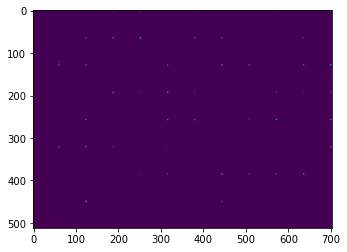

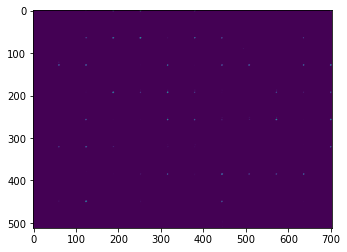

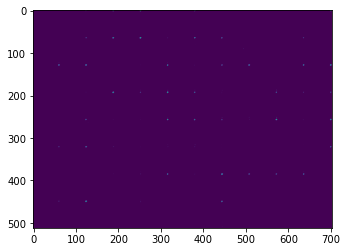

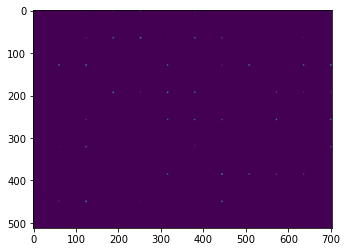

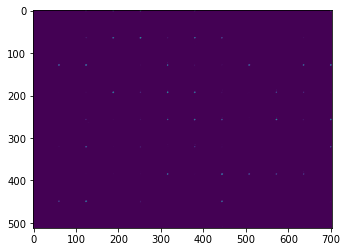

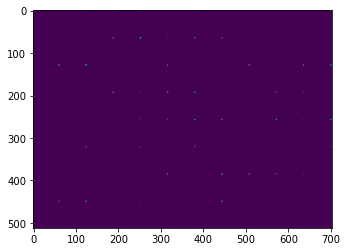

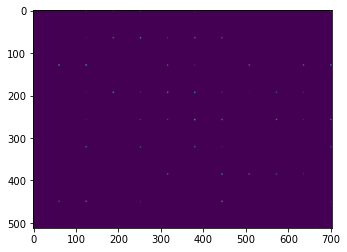

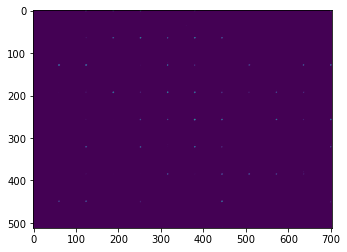

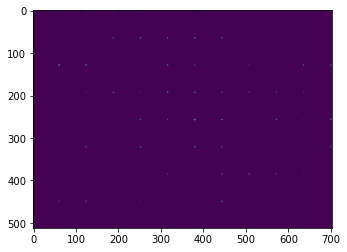

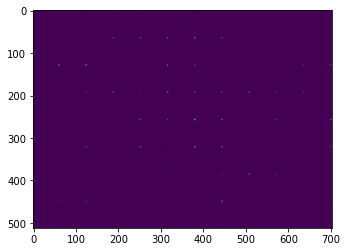

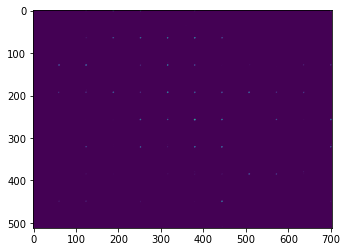

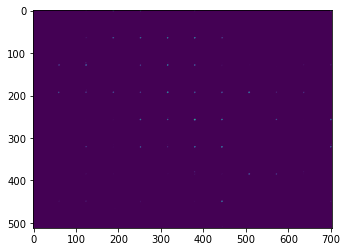

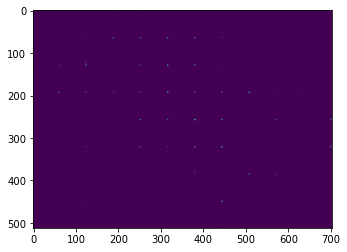

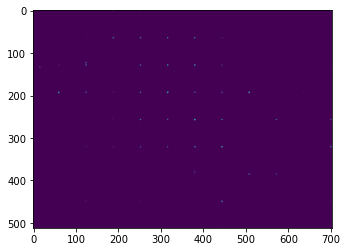

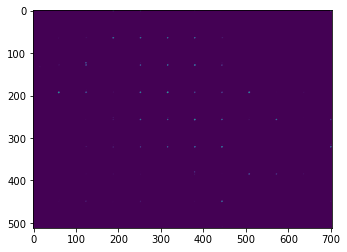

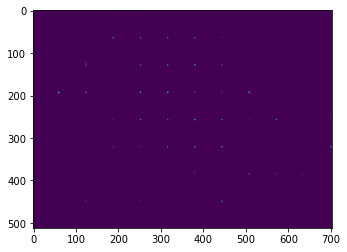

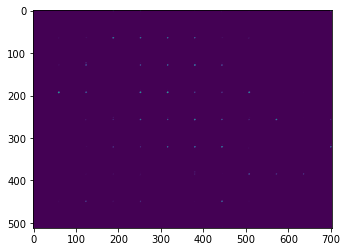

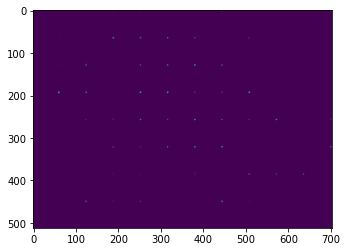

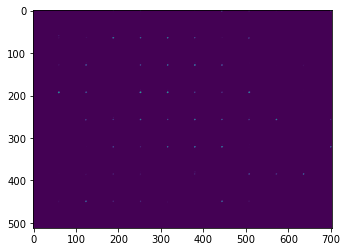

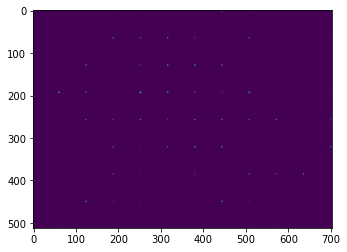

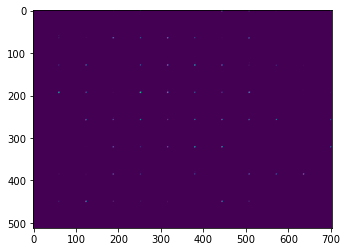

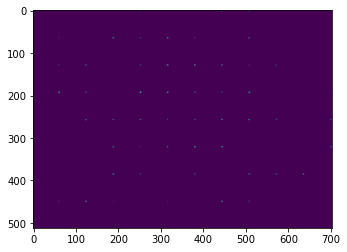

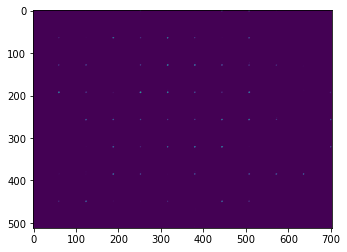

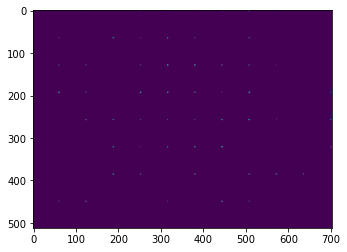

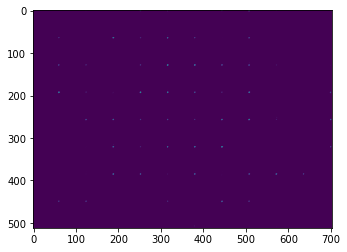

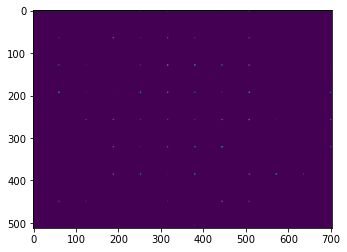

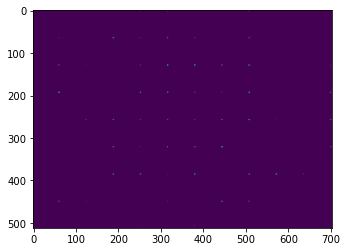

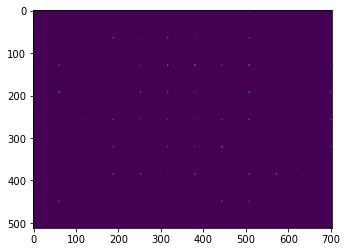

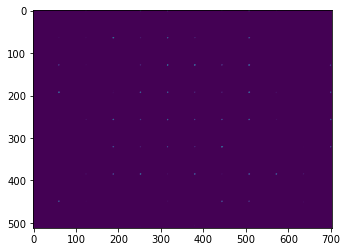

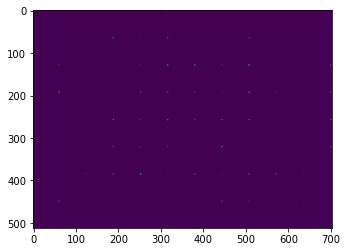

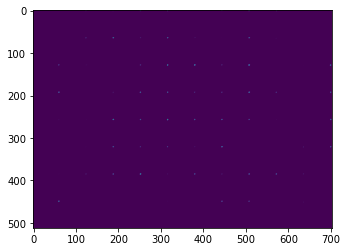

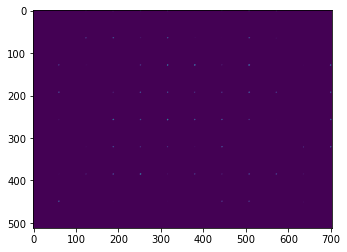

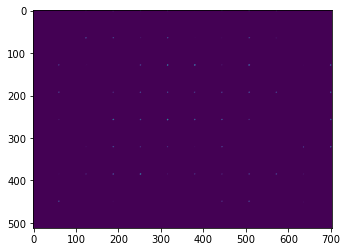

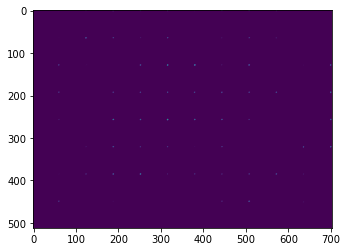

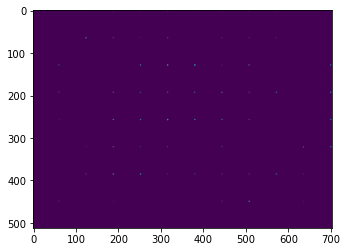

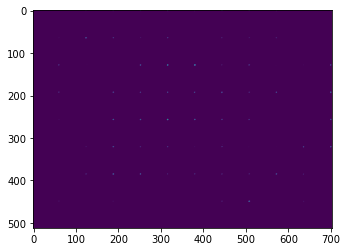

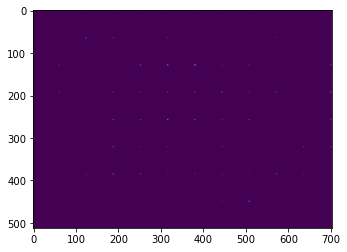

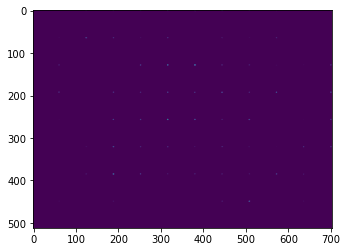

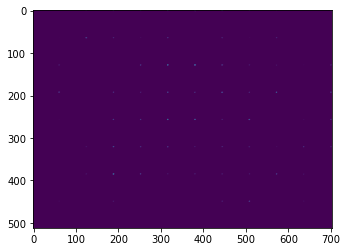

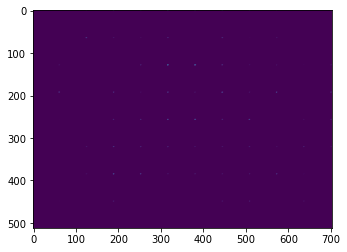

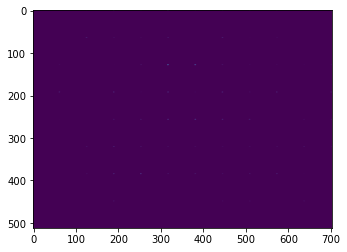

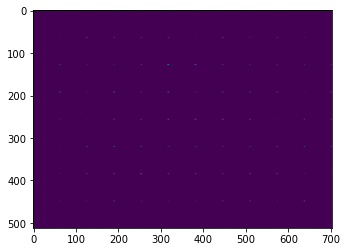

In [12]:
import sagemaker
import urllib
import pandas as pd
import boto3
get_ipython().system('pip install segmentation_models_3D')
get_ipython().system('pip install patchify')
!pip install tensorflow==2.9.2
import sagemaker
import numpy as np
import argparse
import numpy as np
import segmentation_models_3D as sm
import sys
import sagemaker.tensorflow as tf


from keras.models import load_model
from patchify import patchify, unpatchify
from skimage import io
from tifffile import imwrite



def predict(arguments):
    sagemaker_session=sagemaker.Session()
    ###pull the file from the S3 bucket
    print("Bucket name is:")
    sagemaker_session.default_bucket()
    sagemaker_session.download_data("./",sagemaker_session.default_bucket(),'image.tif') #pull the image file from the S3 bucket
    sagemaker_session.download_data("./",sagemaker_session.default_bucket(),'model.h5')#pull the model file from the S3 bucket

    ###input the model weight from the model.h5
    MODEL_LOCATION ='model.h5'
    JSON_LOCATION = ''
    WEIGHTS_LOCATION = ''
    if MODEL_LOCATION!='': 
        from keras.models import load_model
        model = load_model(MODEL_LOCATION,compile=False) #load the model
        print("loaded model from MODEL_LOCATION")

    elif JSON_LOCATION!='': # you have your model saved as a JSON file AND weights
    #adapted from https://machinelearningmastery.com/save-load-keras-deep-learning-models/
        from keras.models import model_from_json
        json_file = open(JSON_LOCATION, 'r')
        loaded_model_json = json_file.read()
        json_file.close()

        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights(WEIGHTS_LOCATION)
        print("loaded model from JSON_LOCATION and WEIGHTS_LOCATION")
    import tensorflow
    import os
    import tensorflow as tf
    import tensorflow.keras as keras
    from keras import backend as K
    if tensorflow.executing_eagerly():
       tensorflow.compat.v1.disable_eager_execution()
    from tensorflow.python.saved_model import builder
    from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
    from tensorflow.python.saved_model import tag_constants
    model_version = '1'
    export_dir = 'export/Servo/' + model_version
    builder = builder.SavedModelBuilder(export_dir)
    signature = predict_signature_def(
        inputs={"inputs": model.input}, outputs={"score": model.output})
    builder.add_meta_graph_and_variables(
        sess=K.get_session(), tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()


   ### ompile the model to tar.gz file and store the model in s3 bucket
    from keras import backend as K
    import tarfile
    sess= sagemaker.Session()
    model_archive = 'model.tar.gz'
    with tarfile.open(model_archive, mode='w:gz') as archive:
        archive.add('export', recursive=True) 
    model_data = sess.upload_data(path=model_archive, key_prefix='model')




    ### creat endpoint
    from sagemaker.tensorflow.serving import Model
    import tensorflow
    import boto3, re
    from sagemaker import get_execution_role
    role = get_execution_role()
    instance_type = 'ml.c5.xlarge' 
    sm_model = Model(model_data=model_data, 
                     framework_version='2.7',
                     role=role)
    uncompiled_predictor = sm_model.deploy(initial_instance_count=1, instance_type=instance_type) 




    ###start predict the unseen image use endpoint 
    parser = argparse.ArgumentParser(
        description=__doc__,
        formatter_class=argparse.RawDescriptionHelpFormatter)

    parser.add_argument(
        'modelfile',
        help="Model filename",
        type=str)

    parser.add_argument(
        'inputfile',
        help="Input filename",
        type=str)

    parser.add_argument(
        'outputfile',
        help="Output filename",
        type=str)

    args = parser.parse_args(arguments)

    modelfile = args.modelfile
    inputfile = args.inputfile
    outputfile = args.outputfile
    inputimage = io.imread(inputfile)
    model = load_model(MODEL_LOCATION,compile=False) #load the model
    patches = patchify(inputimage, (64, 64, 64), step=64)
    BACKBONE = 'vgg16'  # Try vgg16, efficientnetb7, inceptionv3, resnet50
    preprocess_input = sm.get_preprocessing(BACKBONE)

    predicted_patches = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            for k in range(patches.shape[2]):
                single_patch = patches[i, j, k, :, :, :]
                single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
                single_patch_3ch_input = preprocess_input(
                    np.expand_dims(single_patch_3ch, axis=0))
                single_patch_prediction = model.predict(single_patch_3ch_input)
                single_patch_prediction_result = np.squeeze(
                    single_patch_prediction)
                predicted_patches.append(single_patch_prediction_result)

    predicted_patches = np.array(predicted_patches)

    predicted_patches_reshaped = np.reshape(predicted_patches,
                                            (patches.shape[0], patches.shape[1], patches.shape[2],
                                             patches.shape[3], patches.shape[4], patches.shape[5]))

    reconstructed_image = unpatchify(
        predicted_patches_reshaped, inputimage.shape)
    
    #imwrite(outputfile, reconstructed_image)
    return  inputimage, reconstructed_image
argv = [" ",
        'model.h5',
        'image.tif',
        'output'
        ]

if __name__ == '__main__':
    print("Predicting...")
    input_image, reconstructed_image=predict(argv[1:])
    print("Done.")
from matplotlib import pyplot as plt
###show output in console(optional)
for i in range((input_image).shape[0]):
    plt.imshow(reconstructed_image[i])
    plt.show()
###save the output to another S3 bucket
for i in range(reconstructed_image.shape[0]):
    plt.imsave(f'my_picture_{i}.png', reconstructed_image[i])
    s3 = boto3.resource('s3')
    s3.Bucket(sagemaker_session.default_bucket()).upload_file(f'my_picture_{i}.png', f'output/my_picture_{i}.png')

